In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import spacy

# Load spaCy English model
# If not installed:
# python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [3]:
# CSV files
files = {
    "PG": '1094591345_us.csv',
    "Giant": '1536111825_us.csv',
    "Trek": '1609966547_us.csv',
    "Shimano": '1437969979_us.csv',
    "Ninebot US": '1484302191_us.csv'
}

# English stopwords
stop_words = set(STOPWORDS)

# Phrase-level stoplist (generic, non-informative phrases)
PHRASE_STOPLIST = {
    "this game", "the game", "this app", "the app", "pokemon", "Pokémon", "the Pokémon", "you guys", 
    "a lot", "anything", "everything", "my bike", "an app", "giant", "app", "the bike", "my bike",
    "people", "someone", "anyone", "bike", "an app", "the ride", "your bike", "the scooter", "my scooter",
    "something", "nothing", "segway", "this scooter", "a scooter", "game", "-", "my phone", "trek",
    "the trek central app", "tq", "the motor", "time", "shimano", "my iphone", "battery life", "a ride", "e tube project", 
}

WHITELIST = {
    "battery", "speed", "control", "brake", "range",
    "motor", "power", "app", "connection", "bluetooth",
    "quality", "price", "value", "design", "weight",
    "support", "service", "update", "feature"
}




In [4]:
def extract_noun_phrases(text):
    doc = nlp(text)
    phrases = []

    for chunk in doc.noun_chunks:
        phrase = chunk.text.lower().strip()

        # 1 Phrase-level blacklist
        if phrase in PHRASE_STOPLIST:
            continue

        tokens = [t for t in phrase.split() if t.isalpha()]

        # 2️Minimum length constraint
        if len(tokens) < 2:
            continue

        # 3️POS constraints
        has_noun = False
        has_informative_word = False
        has_whitelist = False

        for token in nlp(phrase):
            if token.pos_ in {"NOUN", "PROPN"}:
                has_noun = True
            if token.text not in stop_words:
                has_informative_word = True
            if token.text in WHITELIST:
                has_whitelist = True

        # 4️ Final filtering logic
        if has_whitelist or (has_noun and has_informative_word):
            phrases.append(phrase)

    return phrases



In [5]:
results = {}

for label, file_path in files.items():
    df = pd.read_csv(file_path)

    if 'content' not in df.columns:
        print(f"{file_path} does not have a 'content' column. Skipping.")
        continue

    # Combine all comments into one text
    text = ' '.join(df['content'].astype(str))

    # Extract noun phrases
    phrases = extract_noun_phrases(text)

    # Count frequencies
    phrase_counts = Counter(phrases)

    results[label] = phrase_counts


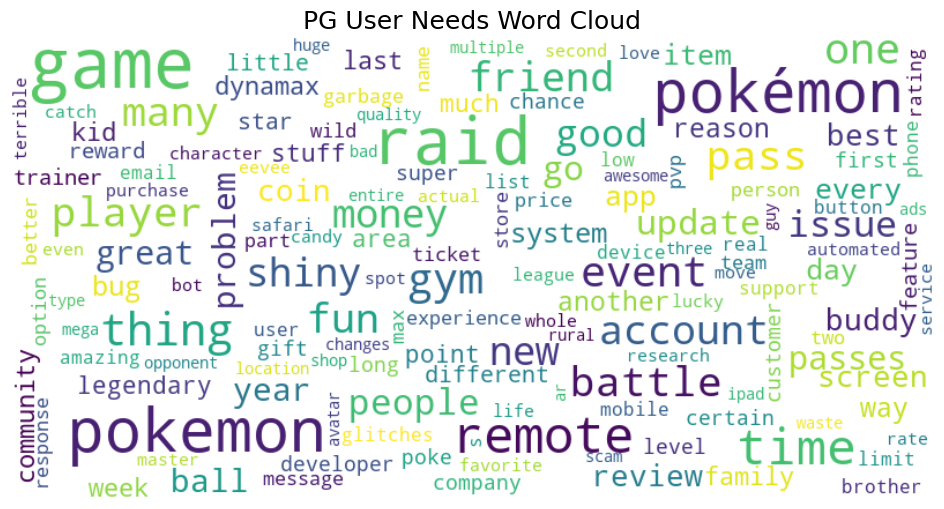

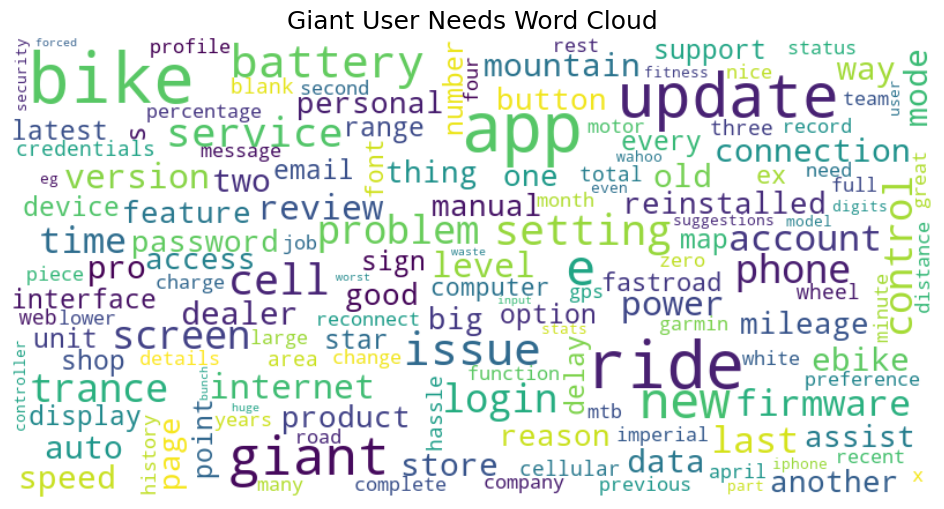

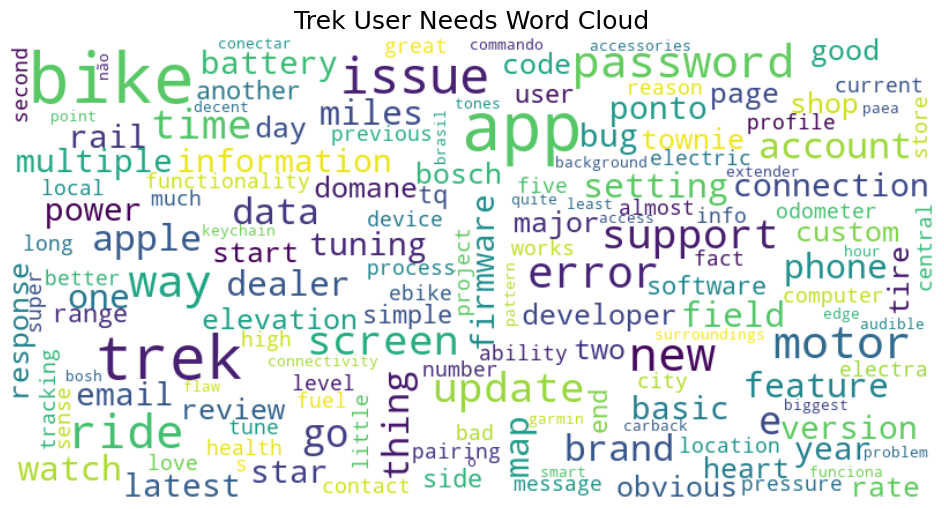

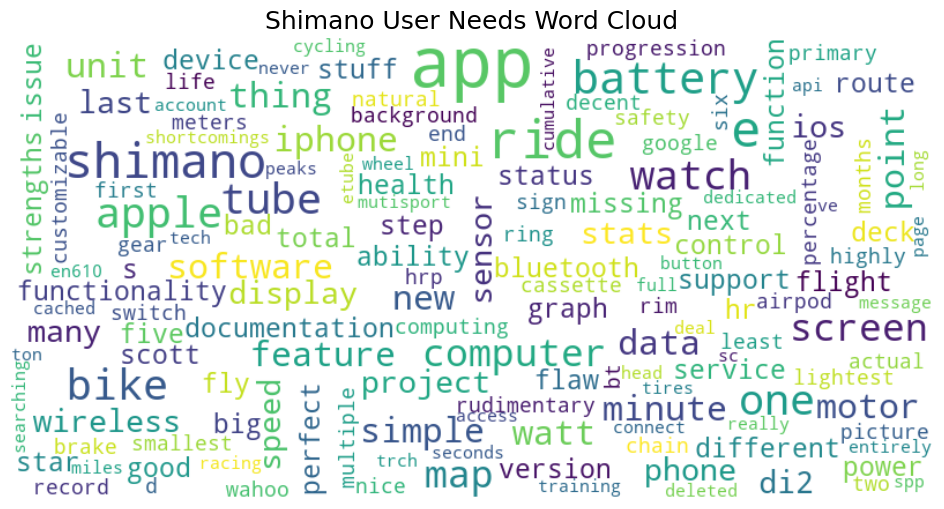

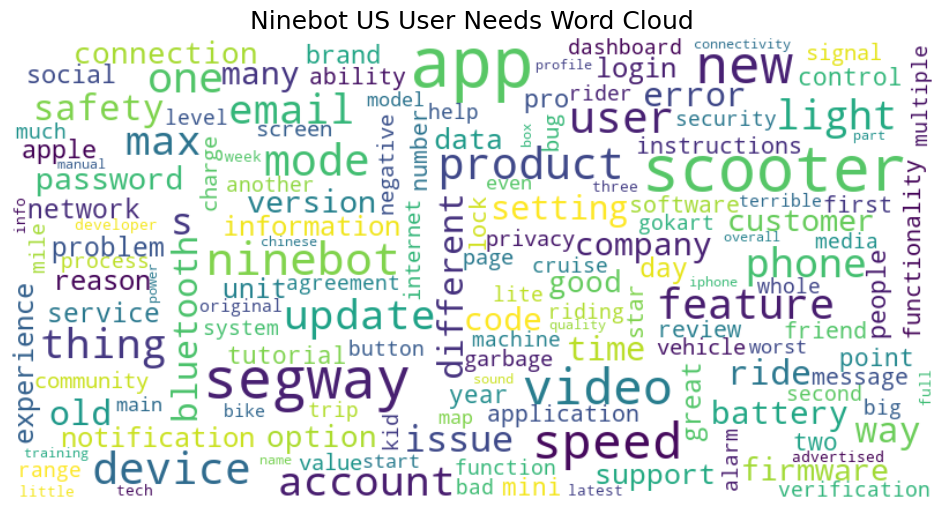

In [6]:
for label, phrase_counts in results.items():

    # Expand phrases according to frequency
    phrase_text = ' '.join(
        phrase for phrase, freq in phrase_counts.items()
        for _ in range(freq)
    )

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=150,
        min_font_size=10,
        max_font_size=60,
        relative_scaling=0.4,   # reduce dominance of top phrases
        collocations=False,
        random_state=42
    ).generate(phrase_text)

    plt.figure(figsize=(15, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{label} User Needs Word Cloud", fontsize=18)
    plt.savefig(f"image_NLP/{label}_wordcloud.png")
    plt.show()


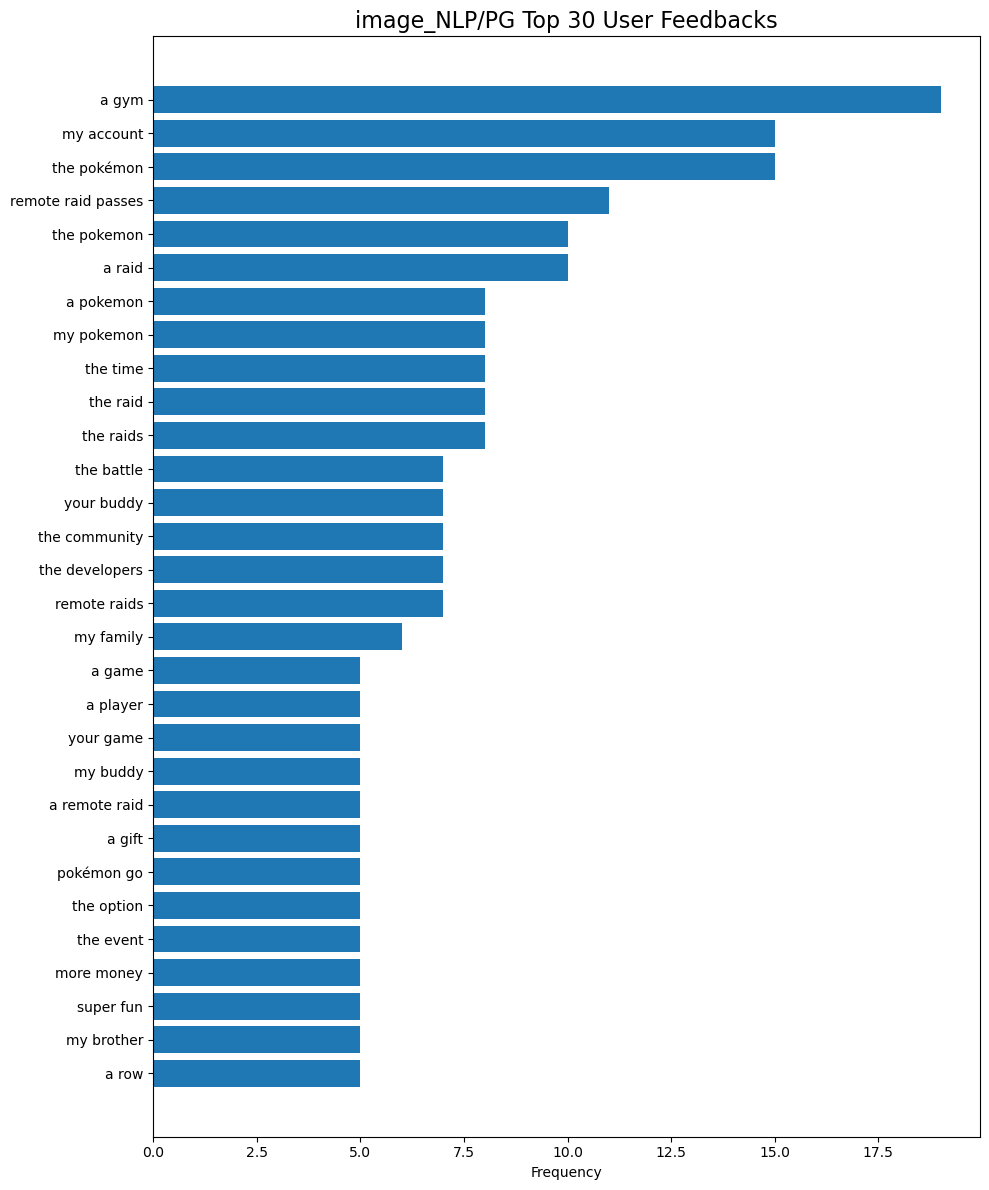

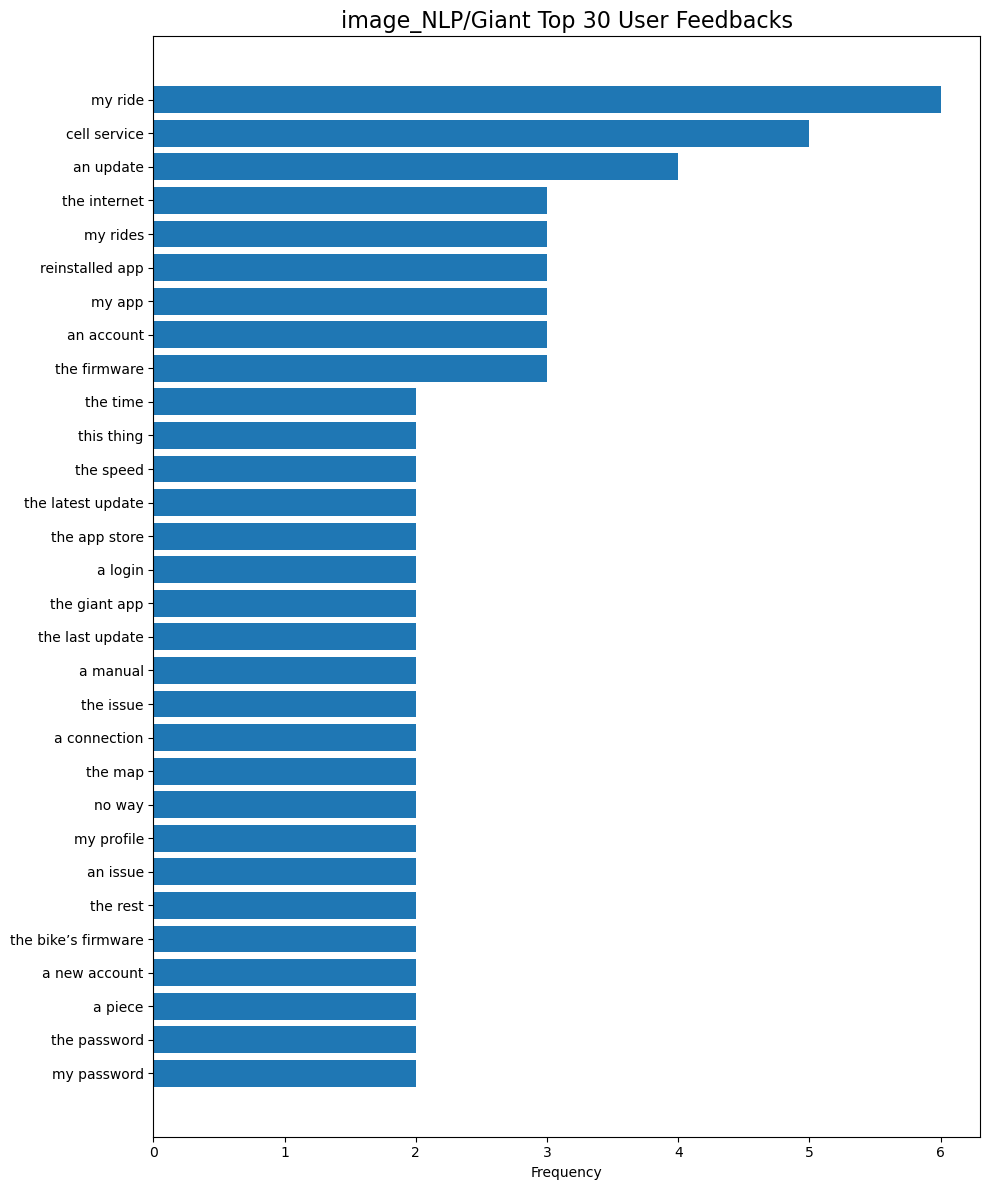

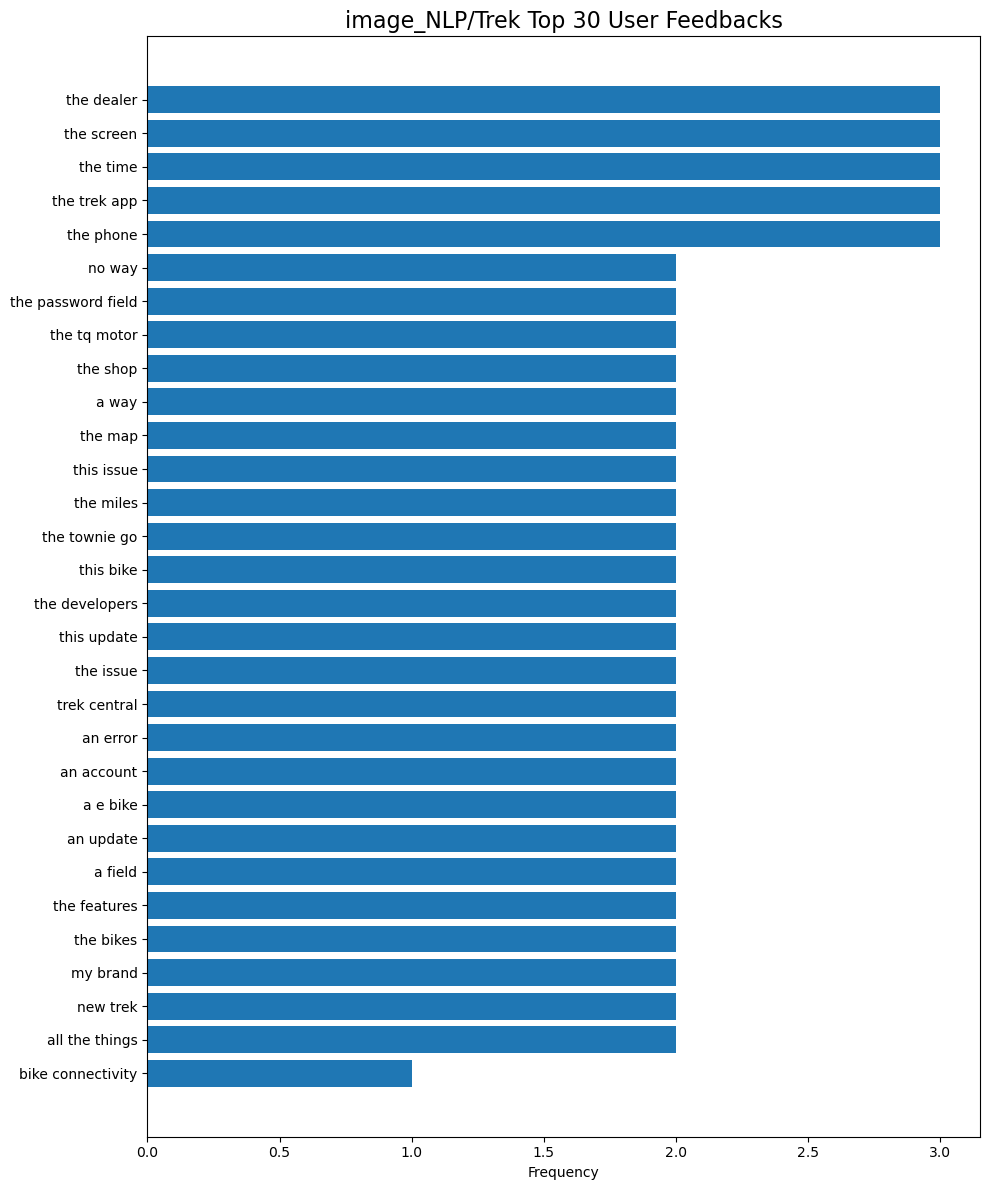

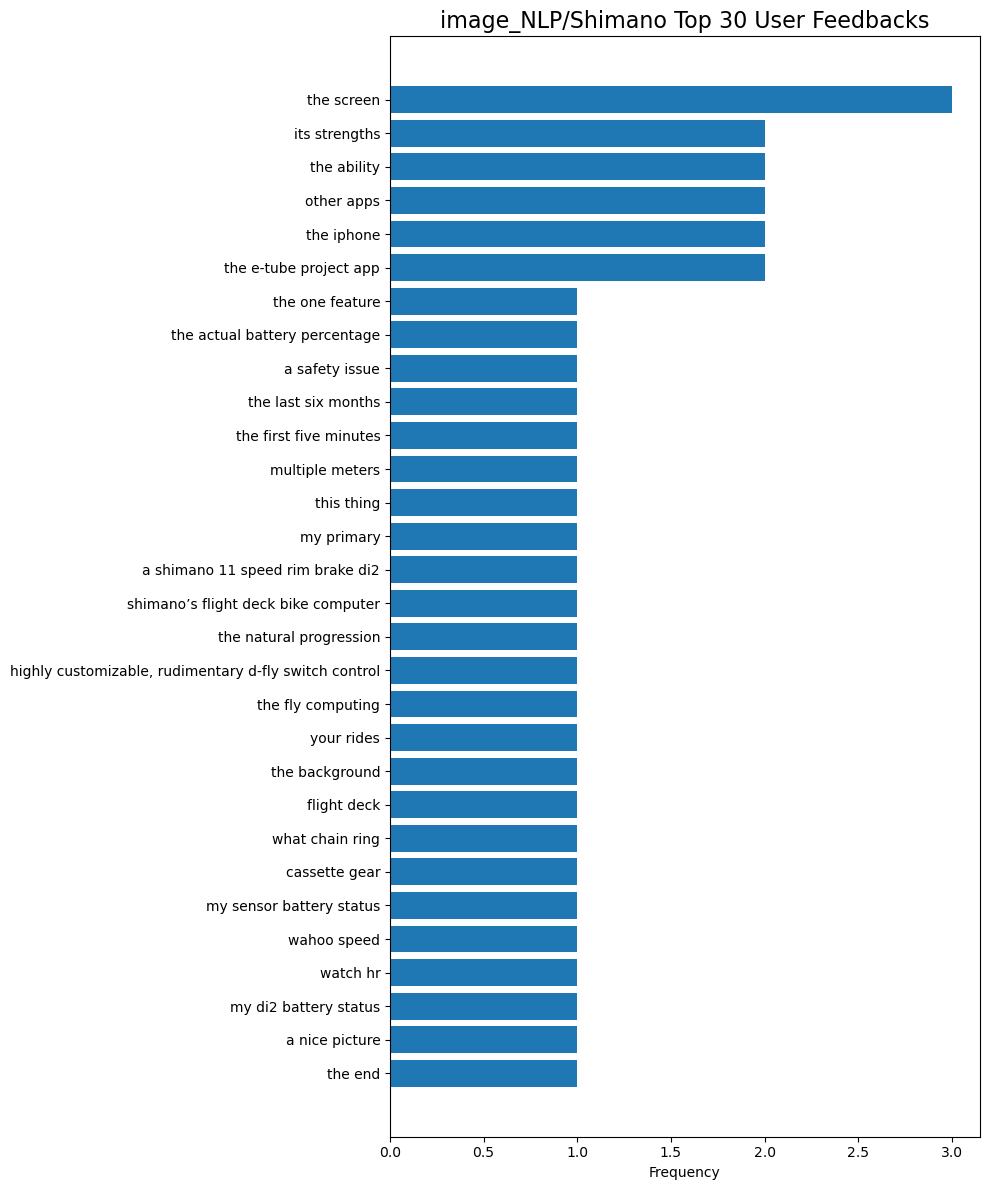

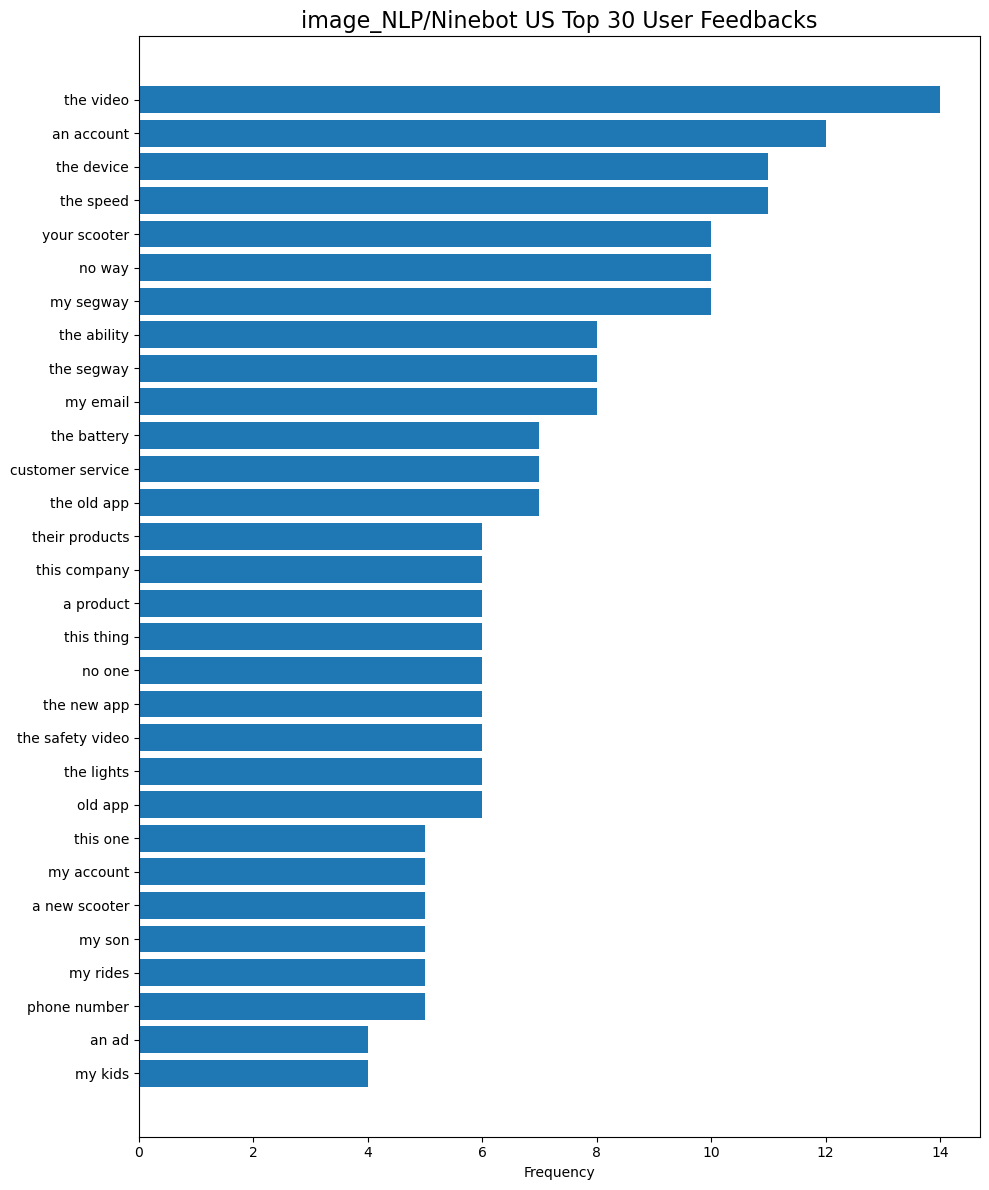

In [7]:
for label, phrase_counts in results.items():

    # Top 30 noun phrases
    top_phrases = phrase_counts.most_common(30)

    if not top_phrases:
        continue

    phrases, frequencies = zip(*top_phrases)

    plt.figure(figsize=(10, 12))
    plt.barh(phrases[::-1], frequencies[::-1])
    plt.xlabel("Frequency")
    plt.title(f"image_NLP/{label} Top 30 User Feedbacks", fontsize=16)
    plt.tight_layout()
    plt.show()
